データセットの生成
-------------------
- [0, 1]の乱数を8こ持った特徴量(feature_vector)を生成
- 実験群か統制群か(is_treat)を乱数で決め、それぞれの場合について内部コンバージョンレートを決める
- 内部コンバージョンレートはfeatture_vectorとbase_weightの内積で定義する
    - 実験群であった場合はfeature_vectorとlift_weightの内積を加算する

In [8]:
import random
def generate_sample_data(num,  seed=1):
    # 返却するリストを確保
    is_cv_list = []
    is_treat_list = []
    feature_vector_list =[]
    
    random_instance = random.Random(seed)
    print(random_instance)
    
    feature_num = 8
    # 重みが0の変数は、観測できているがコンバージョンに寄与しない変数を意味する
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]
        
    for i in range(num):
        # 特徴ベクトルで乱数を生成(randomは0.0-1.0を返す)
        feature_vector = [random_instance.random() for n in range(feature_num)]
        # 実験群かどうかを乱数で決定
        is_treat = random_instance.choice((True, False))
        # 内部的なコンバージョンレートを算出
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])
        
        if is_treat:
            # 実験群であれば、lift_weightを加味する
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
           
        # 実際にコンバージョンしたかどうかを決定する
        is_cv = cv_rate > random_instance.random()
        
        # 生成した値を格納
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
    # 値を返す
    return is_cv_list, is_treat_list, feature_vector_list

2つの予測モデルを利用したUpliftModeling
-------------------------------

- まずは学習用のサンプルデータを作成してコンバージョンレートを計測する

In [9]:
# trainデータの作成
sample_num = 1000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = \
    generate_sample_data(sample_num, seed=1)

# データをtreatmentとcontrolに分離
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])
# コンバージョンレートを表示
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))

treatment_cvr 0.041666666666666664
control_cvr 0.05040322580645161


- 現状の結果では統制群と実験群の差は殆どない

- 次に学習器を構築してtrainデータの学習を行う
- コンバージョン予測の問題であるため、このようなケースでよく使われるロジスティック回帰を使用

In [12]:
from sklearn.linear_model import LogisticRegression

# 学習器の生成
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# 学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

- 2つの予測モデルを利用したUpliftModelingの場合、統制群の予測値と実験群の予測値の2つが得られる
- このままだと扱いにくいため一次元の値に変換する

### 説得可能な顧客と天邪鬼な顧客
- 統制群の予測値が低く、実験群の予測値が高い場合、説得可能な顧客なので高いスコアになって欲しい
- 統制群の予測値が高く、実験群の予測値が低い場合、天邪鬼な顧客なので低いスコアになって欲しい

したがって、予測地の比または差を利用することで、説得可能な顧客は高いスコアに、天邪鬼な顧客は低いスコアに変換することができる。今回は予測値の比を利用する

$$ PuliftModelingのスコア=\frac{実験群の予測値}{統制群の予測値} $$

In [13]:
# seedを変えて、テストデータを生成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = \
    generate_sample_data(sample_num, seed=42)

# それぞれの学習器でコンバージョンレートを予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# スコアの算出、スコアは実験群の予測CVR / 統制群の予測CVR
# predict_probaはクラス所属確率のリストを返すため1番目を参照する
# numpy.ndarrayなので、そのまま割り算しても、要素の割り算になる
score_list = treat_score[:,1] / control_score[:,1]

- scikit-learnのクラス分類機はpredict_proba関数をもっており、特徴ベクトルを引数に与えると、numpy.ndarray型の配列でクラスの所属確率を得ることができる
- 今回はクラスがTrue,Falseの2個であることがわかっているので配列の1番目の値を参照する(Trueの値)
- model.classes_を参照することで、どのクラスが何番目に格納されているかがわかる

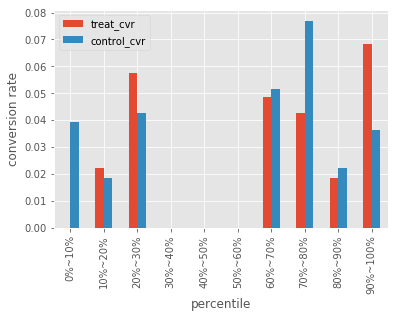

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

# スコアが高い順に並べる
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)
qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 結果を10%ごとに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) *  len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # 実験群と統制群の数を数える
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    controll_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    # 実験群と統制群のコンバージョン数を計測
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
   
    # コンバージョンレートに変換し、表示用のDataFrameに格納
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / controll_uu
    
    label = "{}%~{}%".format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

UpliftModelingの評価方法、AUUC
---------------------
- Uplift Modelingの評価にはAreaUnder the UpliftCurve(AUUC)という指標を使います
- AUUCが大きければ大きいほど性能はよい
- AUUCの算出にはliftという指標を用いる
    - あるスコア以上の顧客には、介入行為を行い、有るスコア未満の顧客には介入行為は行わない場合、介入行為を行わなかった場合と比較してどのくらいコンバージョンが上がったか

### AUUCの手順
- スコアが高い順に操作し、その時点までのコンバージョンレートを計測する
- コンバージョンレートの差から介入行為によるコンバージョンの上昇すう(lift)を算出する
- ランダムに介入を行った場合の想定コンバージョン上昇数として、liftの原点と終点を結んだ直線をベースライン(base_line)とする
- liftとbase_listに囲まれた領域の面積を算出して、正規化し、これをAUUCとする


In [15]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0
control_cvr = 0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu